<a href="https://colab.research.google.com/github/Litos23/IAyRN-Repo-6to-Sem/blob/main/PIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Alek Cazarez Moya IMTC 2006844
#Axel Alonso Medrano Alanis IMTC 1581338
#Carlos Antonio Macias González IMTC 2127909
#Eliezer Ricardo Herrera Oliva IMTC 1995385

In [ ]:
!pip install --upgrade pillow
!pip install kaggle

In [ ]:
# Subir el archivo kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"litos23","key":"08238784f728993d45f62220bd66e789"}'}

In [ ]:
# Configurar la autenticación de Kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Descargar el conjunto de datos desde Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# Descomprimir el archivo descargado
!unzip chest-xray-pneumonia.zip -d /content/chest_xray
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0

In [ ]:
from PIL import Image
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Función para obtener la resolución más baja en un directorio
def get_lowest_resolution(directory):
    min_width, min_height = float('inf'), float('inf')
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(subdir, file))
                width, height = img.size
                min_width = min(min_width, width)
                min_height = min(min_height, height)
    return min_width, min_height

# Función para redimensionar imágenes a la resolución más baja
def resize_images(directory, target_size):
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(subdir, file)
                img = Image.open(img_path)
                # Usar Image.Resampling.LANCZOS en lugar de Image.ANTIALIAS
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                img.save(img_path)

# Función para aumentar datos en la clase minoritaria
def augment_class(directory, target_class, target_size, augmentation_generator):
    class_dir = os.path.join(directory, target_class)
    files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('png', 'jpg', 'jpeg'))]

    while len(files) < target_size:
        for file in files:
            img = Image.open(file)
            img_array = np.array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            for augmented_img in augmentation_generator.flow(img_array, batch_size=1, save_to_dir=class_dir,
                                                             save_prefix='aug', save_format='jpeg'):
                break
            files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
            if len(files) >= target_size:
                break

# 1. Transformar todas las imágenes a la resolución más baja
train_dir = '/content/chest_xray/chest_xray/train'
lowest_resolution = get_lowest_resolution(train_dir)
print(f"Resolución más baja encontrada: {lowest_resolution}")
resize_images(train_dir, lowest_resolution)

Resolución más baja encontrada: (384, 127)


In [ ]:
def augment_class(directory, target_class, target_size, augmentation_generator):
    class_dir = os.path.join(directory, target_class)
    files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('png', 'jpg', 'jpeg'))]

    while len(files) < target_size:
        for file in files:
            img = Image.open(file)
            img_array = np.array(img)

            # Asegurarse de que la imagen tenga 3 canales (RGB)
            if len(img_array.shape) == 2:  # Imagen en escala de grises
                img_array = np.stack((img_array,) * 3, axis=-1)

            # Expandir dimensiones para agregar el batch (1,)
            img_array = np.expand_dims(img_array, axis=0)

            # Aumentar la imagen
            for augmented_img in augmentation_generator.flow(img_array, batch_size=1, save_to_dir=class_dir,
                                                             save_prefix='aug', save_format='jpeg'):
                break

            # Actualizar la lista de archivos después de generar nuevas imágenes
            files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
            if len(files) >= target_size:
                break

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.7521 - loss: 0.8042 - val_accuracy: 0.5000 - val_loss: 2.0176
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.9411 - loss: 0.1875 - val_accuracy: 0.6250 - val_loss: 1.0974
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 435s 4s/step - accuracy: 0.9576 - loss: 0.1384 - val_accuracy: 0.8750 - val_loss: 0.1579
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.9542 - loss: 0.1276 - val_accuracy: 0.7500 - val_loss: 0.7373
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 452s 5s/step - accuracy: 0.9667 - loss: 0.0888 - val_accuracy: 0.8125 - val_loss: 0.3598


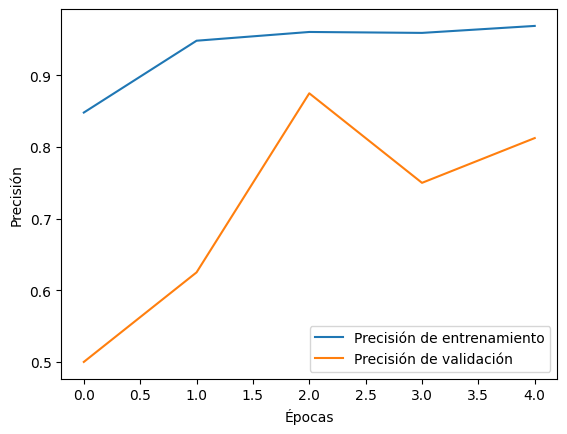

In [ ]:
# Configurar generadores con las imágenes redimensionadas
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=lowest_resolution,
    batch_size=32,
    class_mode='binary'
)

validation_dir = '/content/chest_xray/chest_xray/val'
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=lowest_resolution,
    batch_size=32,
    class_mode='binary'
)

# Definición del modelo CNN
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(lowest_resolution[1], lowest_resolution[0], 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50
)

# Graficar precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()

Por favor, sube hasta 5 imágenes para la predicción


Saving person1954_bacteria_4886.jpeg to person1954_bacteria_4886 (2).jpeg
Saving person1950_bacteria_4881.jpeg to person1950_bacteria_4881 (2).jpeg
Saving person1946_bacteria_4875.jpeg to person1946_bacteria_4875 (2).jpeg
Saving NORMAL2-IM-1436-0001.jpeg to NORMAL2-IM-1436-0001 (2).jpeg
Saving NORMAL2-IM-1427-0001.jpeg to NORMAL2-IM-1427-0001 (2).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Predicción para person1954_bacteria_4886 (2).jpeg: Pneumonia (Confianza: 1.00)


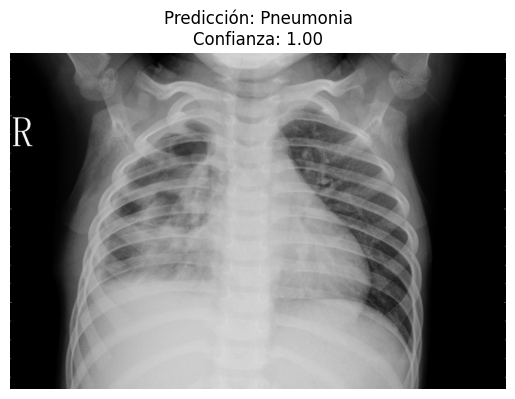

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicción para person1950_bacteria_4881 (2).jpeg: Pneumonia (Confianza: 1.00)


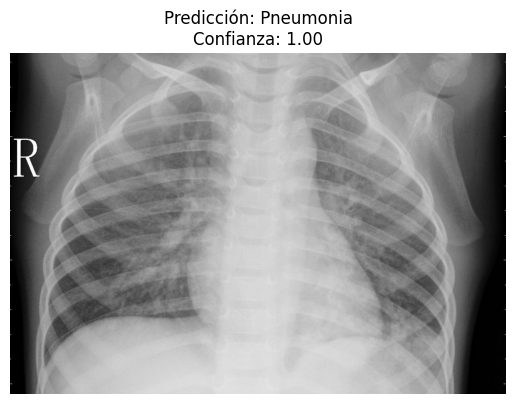

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicción para person1946_bacteria_4875 (2).jpeg: Pneumonia (Confianza: 1.00)


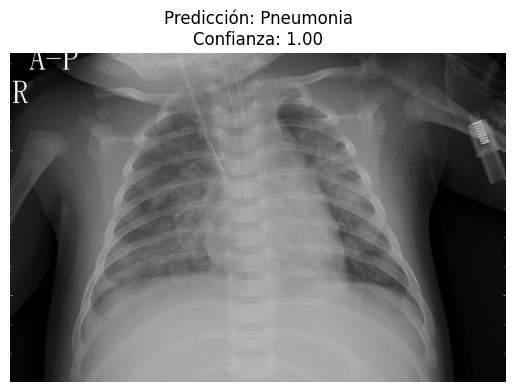

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Predicción para NORMAL2-IM-1436-0001 (2).jpeg: Pneumonia (Confianza: 0.65)


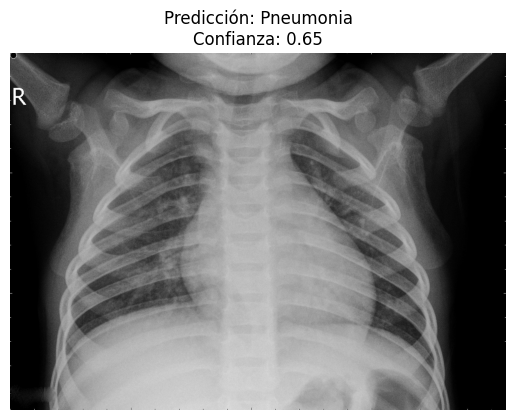

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicción para NORMAL2-IM-1427-0001 (2).jpeg: Normal (Confianza: 0.04)


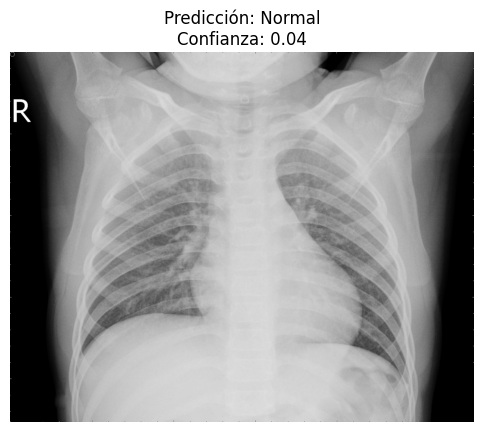

In [ ]:
# Importar bibliotecas necesarias
from tensorflow.keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# Función para predecir si una imagen es "Pneumonia" o "Normal"
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(384, 127))  # Tamaño debe coincidir con el usado en entrenamiento
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalización
    prediction = model.predict(img_array)[0][0]  # Predicción
    label = "Pneumonia" if prediction > 0.5 else "Normal"
    return label, prediction

# Subir hasta 5 imágenes manualmente desde tu computadora
print("Por favor, sube hasta 5 imágenes para la predicción")
uploaded = files.upload()  # Subir imágenes

# Mostrar predicciones para cada imagen subida
predicted_count = 0  # Contador de predicciones
for img_name in uploaded.keys():
    if predicted_count < 5:  # Limitar a 5 predicciones
        # Realizar predicción
        result, score = predict_image(model, img_name)
        print(f"Predicción para {img_name}: {result} (Confianza: {score:.2f})")

        # Mostrar la imagen con el resultado
        img = image.load_img(img_name)
        plt.imshow(img)
        plt.title(f"Predicción: {result}\nConfianza: {score:.2f}")
        plt.axis('off')
        plt.show()

        predicted_count += 1
    else:
        break
